# Lorenz 80 🌪️

## 📝 Descrição geral

Este código implementa as simulações numéricas do artigo _Attractor Sets and Quasi-Geostrophic Equilibrium_ de E.D. Lorenz (1980), que explora a dinâmica de sistemas atmosféricos através de dois modelos: as Equações Primitivas (PE) e sua aproximação Quase-Geostrófica (QG). 

O trabalho busca reproduzir os resultados originais do artigo, simular atratores formados pelos sistemas dinâmicos e realizar uma comparação entre os modelos PE e QG. As simulações utilizam o método numérico Runge-Kutta de quarta ordem para resolver os sistemas de equações diferenciais.

## 📦 Bibliotecas utilizadas

O código utiliza as bibliotecas `NumPy` para operações matemáticas e manipulação de arrays, e `Matplotlib` para visualização e plotagem dos gráficos.

## 🔢 Vetores e constantes

Todos os vetores e constantes foram definidos seguindo a seção 04, _Choice of numerical values_ do artigo [1], exceto o primeiro elemento do vetor força $F$, i.e., $F_1$. Para as simulações, $F_1 = 0.1$. Este valor definido na seção 05, _Behavior of the model_ do mesmo artigo [1].

In [4]:
import matplotlib.pyplot as plt
import numpy as np

vetor_a = [1, 1, 3]
vetor_b = [
    0.5 * (vetor_a[0] - vetor_a[1] - vetor_a[2]),
    0.5 * (vetor_a[1] - vetor_a[2] - vetor_a[0]),
    0.5 * (vetor_a[2] - vetor_a[0] - vetor_a[1]),
]
c = np.sqrt(3 / 4)

f_inv = 10800
vetor_h = [-1, 0, 0]
vetor_f = [0.1, 0, 0]
g_0 = 8
kappa_0 = 1 / 48
nu_0 = kappa_0


## 🌀 Modelo PE

A função `pe_model()` é uma reprodução das equações (33-35) do artigo [1]. São elas:

$a_i\frac{dx_i}{d\tau} = a_ib_ix_ix_k - c(a_i - a_k)x_iy_k  + c(a_i - a_j)y_ix_k -2c^2y_iy_k - \nu_0a_i^2x_i + a_iy_i - a_iz_i$

$ a_i\frac{dy_i}{d\tau} = -a_ib_kx_iy_k - a_ib_iy_ix_k + c(a_k - a_i)y_iy_k - a_ix_i - \nu_0a_i^2y_i$

$\frac{dz_i}{d\tau} = -b_kx_i(z_k - h_k) - b_i(z_i - h_i)x_k + cy_i(z_k - h_k) - c(z_i - h_i)y_k + g_0a_ix_i - \kappa_0a_iz_i + F_i$ 

### Método de discretização

O método de discretização aplicado pela função `runge_kutta_pe()` foi o RK44 apresentado em [2]:

$\Phi(t, y, h) = \frac{1}{6}(\kappa_1 + 2\kappa_2 + 2\kappa_3 + \kappa_4)$ 

$\begin{cases}
\kappa_1 = f(t, y) \\
\kappa_2 = f(t + h/2, y + (h/2)\kappa_1) \\
\kappa_3 = f(t + h/2, y + (h/2)\kappa_2) \\
\kappa_4 = f(t + h, y + h\kappa_3)
\end{cases}$

In [5]:
def pe_model(x, y, z):

    dx = np.zeros(3)
    dy = np.zeros(3)
    dz = np.zeros(3)

    for i in range(3):
        j = (i + 1) % 3
        k = (i + 2) % 3

        dx[i] = (
            vetor_a[i] * vetor_b[i] * x[j] * x[k]
            - c * (vetor_a[i] - vetor_a[k]) * x[j] * y[k]
            + c * (vetor_a[i] - vetor_a[k]) * x[j] * y[k]
            - c * (vetor_a[i] - vetor_a[j]) * y[j] * x[k]
            - 2 * c**2 * y[i] * y[k]
            - nu_0 * vetor_a[i] ** 2 * x[i]
            + vetor_a[i] * y[i]
            - vetor_a[i] * z[i]
        ) / vetor_a[i]

        dy[i] = (
            -vetor_a[k] * vetor_b[k] * x[j] * y[k]
            - vetor_a[j] * vetor_b[j] * y[j] * x[k]
            + c * (vetor_a[k] - vetor_a[j]) * y[j] * y[k]
            - vetor_a[i] * x[i]
            - nu_0 * vetor_a[i] ** 2 * y[i]
        ) / vetor_a[i]

        dz[i] = (
            -vetor_b[k] * x[j] * (z[k] - vetor_h[k])
            - vetor_b[j] * (z[j] - vetor_h[j]) * x[k]
            + c * y[j] * (z[k] - vetor_h[k])
            - c * (z[j] - vetor_h[j]) * y[k]
            + g_0 * vetor_a[i] * x[i]
            - kappa_0 * vetor_a[i] * z[i]
            + vetor_f[i]
        )

    return dx, dy, dz


def runge_kutta_pe(x_inicial, y_inicial, z_inicial, dias):
    t_final = dias * 8
    dt_tau = 1 / 24
    n_steps = int(t_final / dt_tau)

    t = np.linspace(0, t_final, n_steps)
    x = np.zeros((n_steps, 3))
    y = np.zeros((n_steps, 3))
    z = np.zeros((n_steps, 3))

    x[0] = x_inicial
    y[0] = y_inicial
    z[0] = z_inicial

    for i in range(1, n_steps):
        dx1, dy1, dz1 = pe_model(x[i - 1], y[i - 1], z[i - 1])
        k1x = dt_tau * dx1
        k1y = dt_tau * dy1
        k1z = dt_tau * dz1

        dx2, dy2, dz2 = pe_model(
            x[i - 1] + k1x / 2, y[i - 1] + k1y / 2, z[i - 1] + k1z / 2
        )
        k2x = dt_tau * dx2
        k2y = dt_tau * dy2
        k2z = dt_tau * dz2

        dx3, dy3, dz3 = pe_model(
            x[i - 1] + k2x / 2, y[i - 1] + k2y / 2, z[i - 1] + k2z / 2
        )
        k3x = dt_tau * dx3
        k3y = dt_tau * dy3
        k3z = dt_tau * dz3

        dx4, dy4, dz4 = pe_model(x[i - 1] + k3x, y[i - 1] + k3y, z[i - 1] + k3z)
        k4x = dt_tau * dx4
        k4y = dt_tau * dy4
        k4z = dt_tau * dz4

        x[i] = x[i - 1] + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
        y[i] = y[i - 1] + (k1y + 2 * k2y + 2 * k3y + k4y) / 6
        z[i] = z[i - 1] + (k1z + 2 * k2z + 2 * k3z + k4z) / 6

    t_days = t / 8
    return t_days, x, y, z


## 🌊 Modelo QG

A função `qg_model()` é uma reprodução da equação (43) do artigo [1], apresentada abaixo:

$(a_ig_0 + 1)\frac{dy_i}{d\tau} = g_0c(a_k - a_j)y_jy_k - a_i(a_ig_0v_0 + \kappa_0)y_i - ch_ky_j + ch_jy_k + F_i$ 

### Método de discretização

Assim como o modelo PE, o modelo QG também usou o método RK44 da referência [2]

In [6]:
def qg_model(y):
    dy = np.zeros(3)
    for i in range(3):
        j = (i + 1) % 3
        k = (i + 2) % 3
        dy[i] = (
            g_0 * c * (vetor_a[k] - vetor_a[j]) * y[j] * y[k]
            - vetor_a[i] * (vetor_a[i] * g_0 * nu_0 + kappa_0) * y[i]
            - c * vetor_h[k] * y[j]
            + c * vetor_h[j] * y[k]
            + vetor_f[i]
        ) / (vetor_a[i] * g_0 + 1)
    return dy


def runge_kutta_qg(y0, dias_total):
    t = t = np.arange(0, dias_total)
    n = dias_total
    y = np.zeros((n, len(y0)))
    y[0] = y0
    dt = 1

    for i in range(n - 1):
        k1 = qg_model(y[i])
        k2 = qg_model(y[i] + k1 * dt / 2)
        k3 = qg_model(y[i] + k2 * dt / 2)
        k4 = qg_model(y[i] + k3 * dt)
        y[i + 1] = y[i] + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

    return t, y


## 📊 Visualização dos Resultados

Este estudo utilizou três diferentes abordagens de visualização dos dados:

1. **Evolução Temporal dos Índices Primários**

   Nesta visualização, acompanhamos o comportamento das variáveis $x_1$, $y_1$ e $z_1$ ao longo do tempo. Esta representação foi escolhida para permitir uma comparação direta com a Figura 1 apresentada no artigo de referência [1].

2. **Comportamento do Vetor y**

   Esta visualização mostra como os três componentes do vetor $y$ ($y_1$, $y_2$ e $y_3$) evoluem simultaneamente. Embora esta representação não apareça diretamente nas referências principais, ela foi fundamental para comparar os modelos PE e QG, baseando-se na equivalência descrita nos parágrafos finais da página 1692 do artigo [1].

3. **Projeções Bidimensionais do Vetor y**

   Esta visualização apresenta o atrator do sistema através de três projeções bidimensionais: $y_1 \times y_1$, $y_3 \times y_2$ e $y_1 \times y_3$. As projeções foram escolhidas para validar nossos resultados, comparando-os com os atratores apresentados no artigo [3].

In [7]:
def evolucao_x1y1z1(t, x, y, z, dias):
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(t, x[:, 0], "-", linewidth=1.5, label="x1", color="green")
    ax.plot(t, y[:, 0], "-", linewidth=1.5, label="y1", color="blue")
    ax.plot(t, z[:, 0], "-", linewidth=1.5, label="z1", color="red")

    ax.set_xlim(0, dias)
    ax.set_ylim(-0.4, 0.6)
    ax.set_xlabel("Dias")
    ax.grid(True)
    ax.legend()

    return fig, ax


def plot_evolucao_y(t, y, dias):
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(t, y[:, 0], "-", linewidth=1.5, label="y1", color="green")
    ax.plot(t, y[:, 1], "-", linewidth=1.5, label="y2", color="blue")
    ax.plot(t, y[:, 2], "-", linewidth=1.5, label="y3", color="red")

    ax.set_xlim(0, dias)
    ax.set_ylim(-0.4, 0.6)
    ax.set_xlabel("Dias")
    ax.grid(True)
    ax.legend()

    return fig, ax


def plot_y2y3(y):
    plt.figure(figsize=(12, 4))
    plt.plot(y[:, 2], y[:, 1], "r-", linewidth=1.5)
    plt.xlabel("y3")
    plt.ylabel("y2")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.title("Atrator L80")

    plt.xlim(-0.3, 0.3)
    plt.ylim(-0.5, 0.5)


def plot_y1y3(y):
    plt.figure(figsize=(12, 4))
    plt.plot(y[:, 0], y[:, 2], "r-", linewidth=1.5)
    plt.xlabel("y1")
    plt.ylabel("y3")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.title("Atrator L80")

    plt.xlim(-0.3, 0.6)
    plt.ylim(-0.3, 0.3)


def plot_y3y1(y):
    plt.figure(figsize=(12, 4))
    plt.plot(y[:, 2], y[:, 0], "r-", linewidth=1.5)
    plt.xlabel("y3")
    plt.ylabel("y1")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.title("Atrator L80")

    plt.ylim(-0.25, 0.5)
    plt.xlim(-0.25, 0.25)


## 🔬 Simulações

As simulações são divididas em três partes com base nas diferentes condições iniciais:

### Condição padrão

Nesta simulação, reproduzimos a figura 1 do artigo [1] para observar a evolução temporal das variáveis x_1, y_1 e z_1.

### Condições de Hadley 01

De acordo com [4], as condições de Hadley podem ser aplicadas no Modelo PE através dos seguintes valores:

$x_1 = -v_0a_1y_1$

$y_1 = F_1/a_1v_0(1 + a_1g_0 + v_0^2a_1^2)$

$z_1 = (1 + v_0^2a_1^2)y_1$

$x_2 = x_3 = y_2 = y_3 = z_2 = z_3 = 0$

Esta simulação nos permite estudar os atratores gerados pelo modelo PE.

### Condições de Hadley 02

Conforme o artigo [1], podemos simular as condições de Hadley utilizando as seguintes condições iniciais:

$x_1 = -0.01111$

$y_1 = 0.53331$

$z_1 = 0.53354$

$x_2 = x_3 = y_2 = y_3 = z_2 = z_3 = 0$

Estes valores são equivalentes ao modelo QG quando:

$y_1 = 0.53333$ e $y_2 = y_3 = 0$

Nesta simulação, realizamos uma comparação entre os modelos PE e QG.

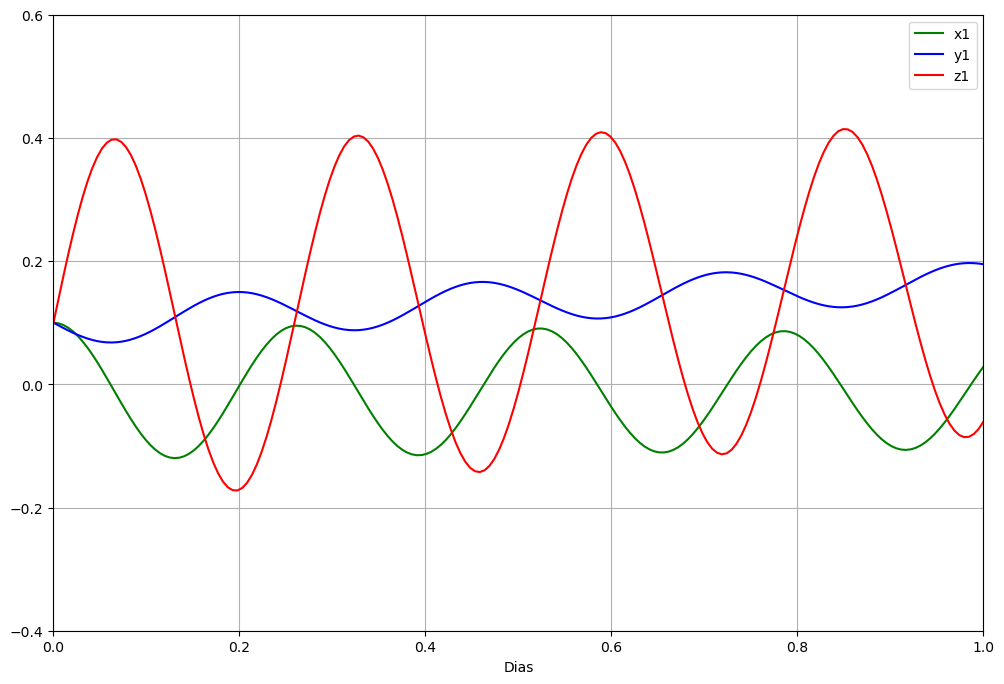

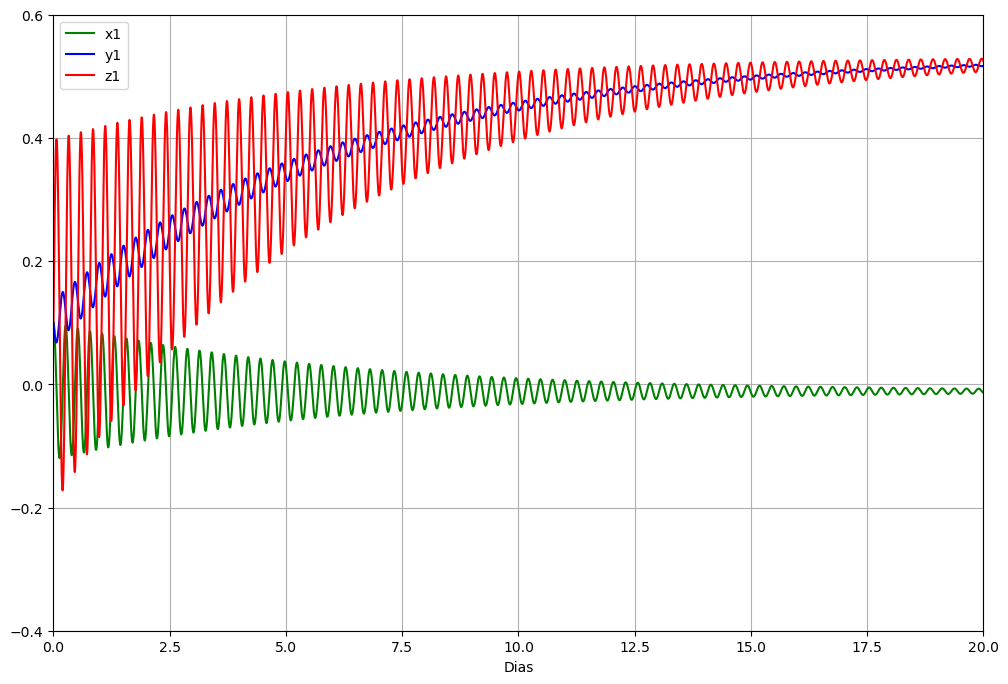

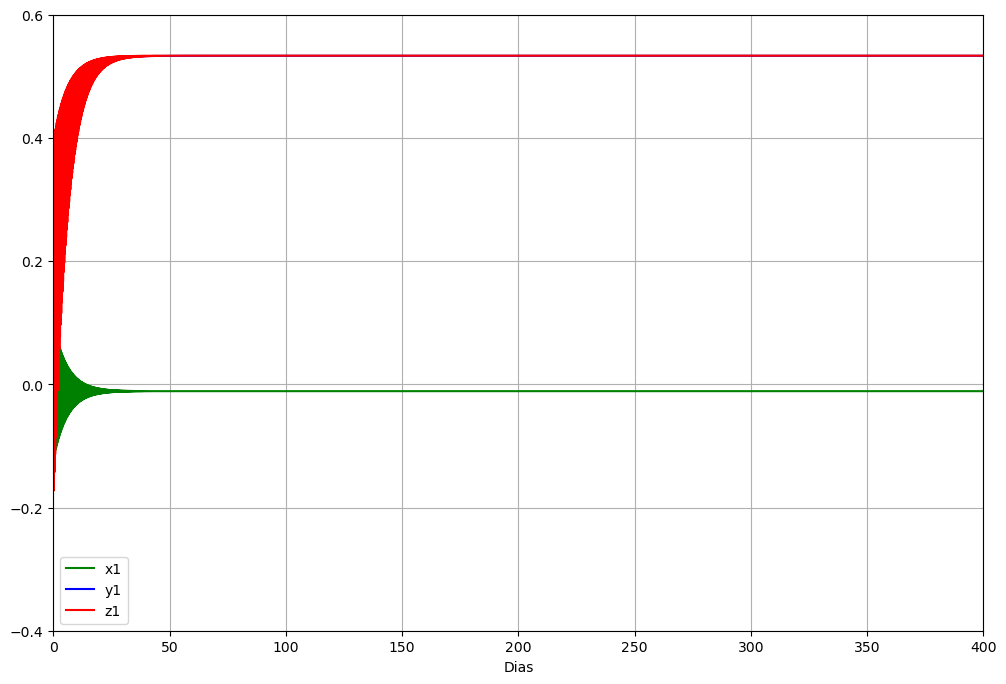

In [8]:
# SIMULAÇÃO CONDIÇÕES PADRÃO - FIGURA 1

# Dias de simulação
dias_total = 400

# Condições iniciais
x0 = [0.1, 0, 0]
y0 = [0.1, 0, 0]
z0 = [0.1, 0, 0]

# Simulação do modelo PE
t_fig1, x_fig1, y_fig1, z_fig1 = runge_kutta_pe(x0, y0, z0, dias_total)

# Plotagem
evolucao_x1y1z1(t_fig1, x_fig1, y_fig1, z_fig1, 1)
evolucao_x1y1z1(t_fig1, x_fig1, y_fig1, z_fig1, 20)
evolucao_x1y1z1(t_fig1, x_fig1, y_fig1, z_fig1, dias_total)
plt.show()


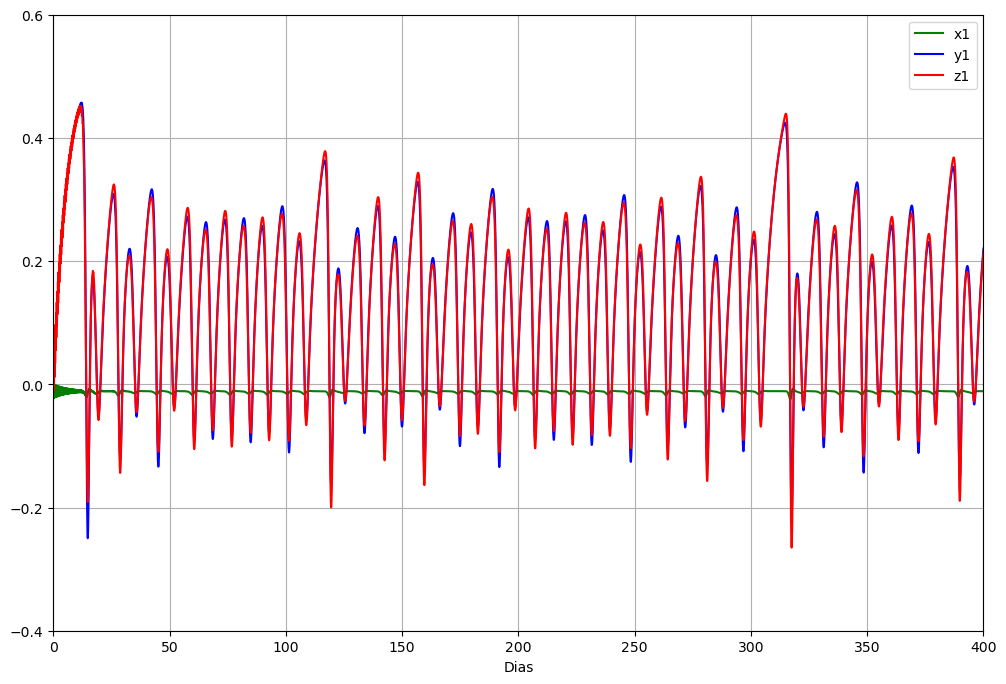

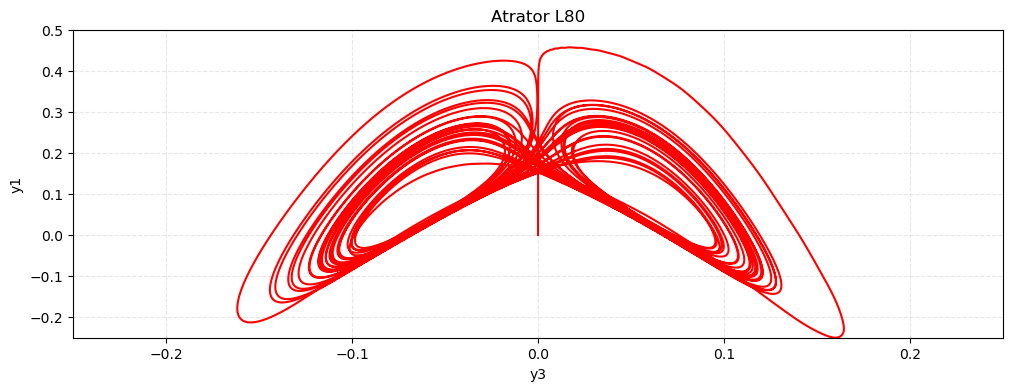

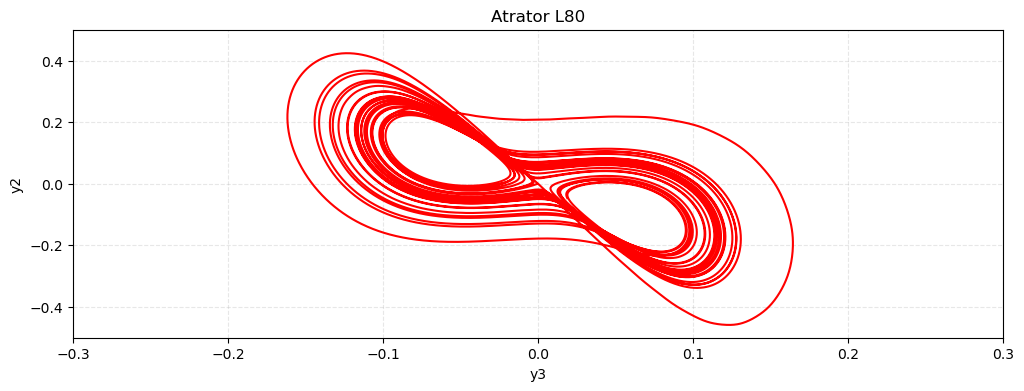

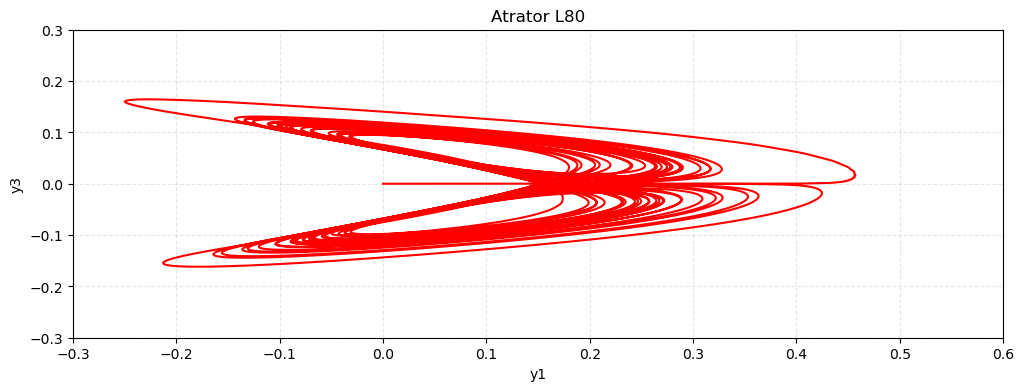

In [9]:
# SIMULAÇÃO CONDIÇÕES DE HARDLEY 01

# Dias de simulação
dias_hardley01 = 400

# Condições iniciais
y1 = (
    vetor_f[1]
    / vetor_a[1]
    * nu_0
    * (1 + vetor_a[1] * g_0 + nu_0**2 * vetor_a[1] ** 2)
)
z1 = (1 + nu_0**2 * vetor_a[1] ** 2) * y1
x1 = -nu_0 * vetor_a[1] * y1

x_hardley01_inicial = [x1, 0, 0]
y_hardley01_inicial = [y1, -(10 ** (-5)), 0]
z_hardley01_inicial = [z1, 10 ** (-5), 0]

# Simulação do modelo PE
t_hardley01, x_hardley01, y_hardley01, z_hardley01 = runge_kutta_pe(
    x_hardley01_inicial, y_hardley01_inicial, z_hardley01_inicial, dias_hardley01
)

# Plotagem
evolucao_x1y1z1(t_hardley01, x_hardley01, y_hardley01, z_hardley01, dias_hardley01)
plot_y3y1(y_hardley01)
plot_y2y3(y_hardley01)
plot_y1y3(y_hardley01)
plt.show()


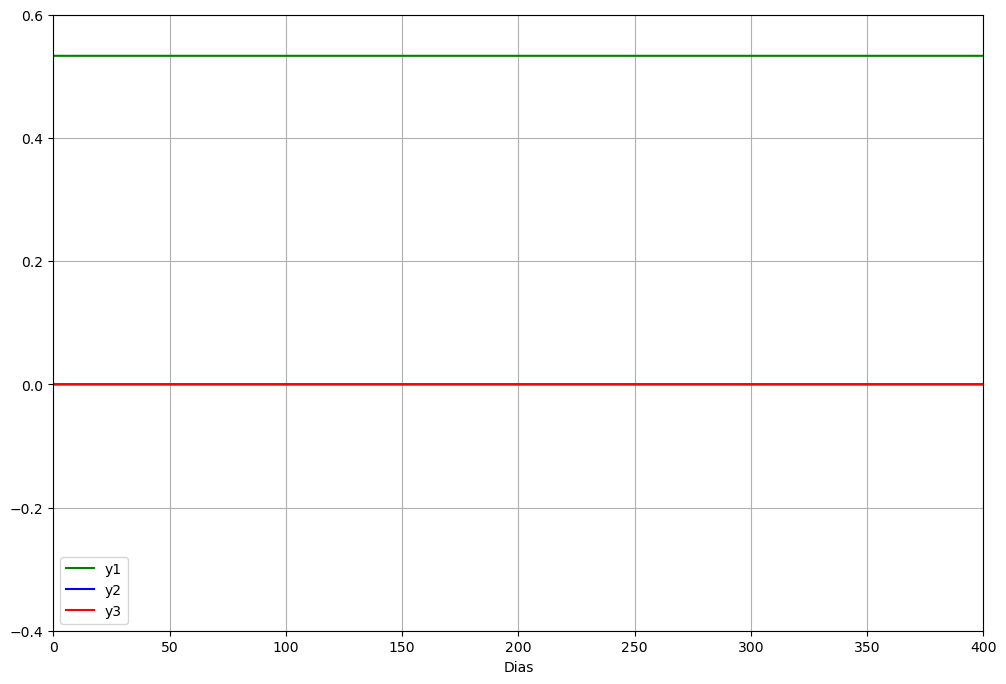

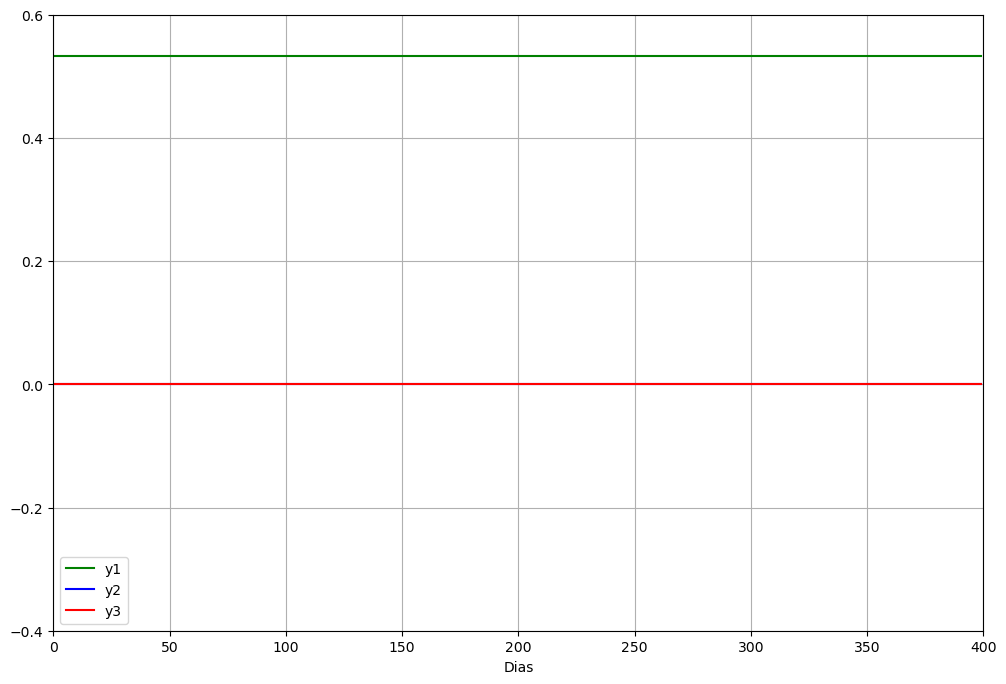

In [10]:
# SIMULAÇÃO CONDIÇÕES DE HARDLEY 02

# Dias de simulação
dias_hardley02 = 400

# Condições iniciais do modelo PE
x_hardley02_inicial = [-0.01111, 0, 0]
y_hardley02_inicial = [0.53331, 0, 0]
z_hardle02_inicial = [0.53354, 0, 0]

# Simulação do modelo PE
t_hardley02, x_hardley02, y_hardley02, z_hardley02 = runge_kutta_pe(
    x_hardley02_inicial, y_hardley02_inicial, z_hardle02_inicial, dias_hardley02
)

# Condições iniciais do modelo QG
y0 = [0.53333, 0, 0]

# Simulação do modelo QG
t0, sol0 = runge_kutta_qg(y0, dias_hardley02)

# Plotagem
plot_evolucao_y(t_hardley02, y_hardley02, dias_hardley02)
plot_evolucao_y(t0, sol0, dias_hardley02)
plt.show()


## 📚 Referências
[1] Lorenz, E. N. (1980). Attractor sets and quasi-geostrophic equilibrium. Journal of the Atmospheric Sciences, 37(8), 1685–1699. https://doi.org/10.1175/1520-0469(1980)037<1685:asaqge>2.0.co;2

[2] Roma, A. M., Bevilacqua, J. S., & Nós, R. L. (2023). Métodos para a solução numérica de equações diferenciais ordinárias a valores iniciais [Notas de aula, curso de Métodos Numéricos, USP]. Material não publicado.
 
[3] Chekroun, M. D., Liu, H., & McWilliams, J. C. (2017). The emergence of fast oscillations in a reduced primitive equation model and its implications for closure theories. Computers & Fluids, 151, 3–22. doi:10.1016/j.compfluid.2016.07.005

[4] Gent, P. R., & McWilliams, J. C. (1982). Intermediate model solutions to the Lorenz equations: Strange attractors and other phenomena. Journal of the Atmospheric Sciences, 39(1), 3–13. doi:10.1175/1520-0469(1982)039<0003:imsttl>2.0.co;2
